In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.optimize import newton
from scipy.integrate import odeint 
from math import *
import time
import random

In [2]:
tf.config.list_physical_devices()

2024-08-04 18:13:36.250377: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 18:13:36.273667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 18:13:36.273788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [88]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel,max,t_final,n_t):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    #use newton to find the zero of the function for the y component of the velocity [3][1] starting from 0
    T_peak = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[3][1], 0)
    y_peak = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, T_peak])[1][1]
    #use newton to find the zero of the y position starting from 2*T_peak
    T = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[1][1], 2 * T_peak)
    #print(T, 2*T_peak)
    if max:
        t = np.linspace(0, T, 101)
    else:
        t = np.linspace(0, t_final, n_t)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
alpha0  = radians(75)  # Launch angle (deg.)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

In [209]:
def gerar_e_plotar_dados(angulo0, velocidade0, n, plot=False):
    indices = random.sample(range(1, 20), n)
    X, Y, T = makepath(angulo0, velocidade0,True,1,1)
    X = tf.convert_to_tensor(X, dtype='float32')
    X = tf.expand_dims(X, 1)
    Y = tf.convert_to_tensor(Y, dtype='float32')
    Y = tf.expand_dims(Y, 1)
    T = tf.convert_to_tensor(T, dtype='float32')
    T = tf.expand_dims(T, 1)
    Traj = tf.concat([X, Y], axis=1)
    
    x_data = tf.gather(T, indices)
    y_data = tf.gather(Traj, indices)
    
    ruido_y = tf.random.normal(shape=y_data.shape, mean=0.0, stddev=0.005 * tf.abs(y_data))
    y_data_ruidoso = y_data + ruido_y
    
    if plot:
        plt.figure()
        plt.plot(X, Y, label="Solução exata")
        plt.scatter(y_data_ruidoso[:, 0], y_data_ruidoso[:, 1], color="tab:green", label="Dados para treino com ruído")
        plt.xlabel('t')
        plt.ylabel('s')
        plt.legend()
        plt.show()
    
    return x_data, y_data_ruidoso, X, Y, T


In [190]:
# x da EDO, com 30 pontos
x_phys = tf.linspace(0,20,200)
x_phys = tf.cast(x_phys, tf.float64)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
epochs = 100000 #uns 780 seg no colab
k_phy_loss1=(1e1) # coloque zero nesta grandeza para uma FF!
k_phy_loss2=(1e1)
k_phy_loss3 = (1e1)

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 64
hidden_dim2 = 64
output_dim = 2


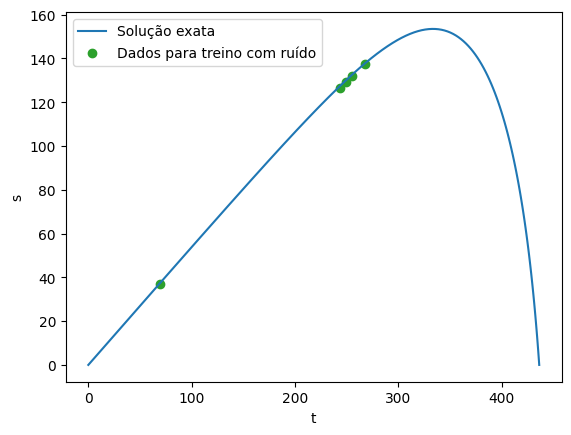

In [186]:
angulo0,velocidade0 = 28.34,1097.08
x_data,y_data,X,Y,T = gerar_e_plotar_dados(angulo0,velocidade0,5,plot=True)
model_keras=Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')


In [198]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data, dtype='float32')
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) #calcula as saidas da rede nos pontos "experimentais"
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))
        with tf.GradientTape() as t2:
            t2.watch(x_phys)
            with tf.GradientTape() as t1:
                t1.watch(x_phys)
                yhp = model_keras(x_phys) #calcula as saidas da rede nos pontos escolhidos para ajustar a EDO
            dx  = tf.reshape(t1.batch_jacobian(yhp, x_phys),(-1,2)) # calcula dy/dx que é igual a ds/dt
        dx2 = tf.reshape(t2.batch_jacobian(dx, x_phys),(-1,2)) # calcula d^2y/dx^2 que é igual a d^2s/dt^2
        vx = dx[:,0]
        vy = dx[:,1]
        dvx = dx2[:,0]
        dvy = dx2[:,1]
        V = tf.sqrt(tf.square(vx)+tf.square(vy))        
        physics1 = tf.cast(tf.reduce_mean(tf.square(dvx+mu*vx*V)),"float32")
        physics2 = tf.cast(tf.reduce_mean(tf.square(dvy+g+mu*vy*V)),"float32")
        physics3 =  tf.cast(tf.reduce_mean(tf.square(yhp[0,0])),"float32")
        physics4 =  tf.cast(tf.reduce_mean(tf.square(yhp[0,1])),"float32")
        Phys_loss1 = k_phy_loss1*physics1
        Phys_loss2 = k_phy_loss2*physics2 
        Phys_loss3 = k_phy_loss3*physics3
        Phys_loss4 = k_phy_loss3*physics4
        
        data_loss = tf.cast(data_loss, "float32")
        loss = Phys_loss1 + Phys_loss2 + Phys_loss3 + Phys_loss4 + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))

    return Phys_loss1 + Phys_loss2, Phys_loss3+Phys_loss4, data_loss, loss

#loss = training_step(x_data,y_data)
#print(loss)


In [199]:
start_time = time.time()
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,l4 = loss
    #h_loss.append(l4)
    #h_data_loss.append(l3)
    #h_Phys_loss.append(l1+l2)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l4}, Data Loss: {l3}, Physics Loss: {l1+l2}")
    if l4<=1e-4:
       break
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 500/100000, Loss: 2.623478412628174, Data Loss: 1.7301247119903564, Physics Loss: 0.8933536410331726
Epoch 1000/100000, Loss: 1.9748866558074951, Data Loss: 1.6949485540390015, Physics Loss: 0.27993810176849365
Epoch 1500/100000, Loss: 1.8485139608383179, Data Loss: 1.6805851459503174, Physics Loss: 0.1679288148880005
Epoch 2000/100000, Loss: 1.7587028741836548, Data Loss: 1.6492893695831299, Physics Loss: 0.10941344499588013
Epoch 2500/100000, Loss: 1.777175784111023, Data Loss: 1.6372394561767578, Physics Loss: 0.13993629813194275
Epoch 3000/100000, Loss: 1.8644688129425049, Data Loss: 1.6336065530776978, Physics Loss: 0.23086220026016235
Epoch 3500/100000, Loss: 2.205994129180908, Data Loss: 1.6362804174423218, Physics Loss: 0.569713830947876
Epoch 4000/100000, Loss: 1.7386503219604492, Data Loss: 1.6193634271621704, Physics Loss: 0.11928696185350418
Epoch 4500/100000, Loss: 2.9766201972961426, Data Loss: 1.621604561805725, Physics Loss: 1.355015754699707
Epoch 5000/100000, Lo

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

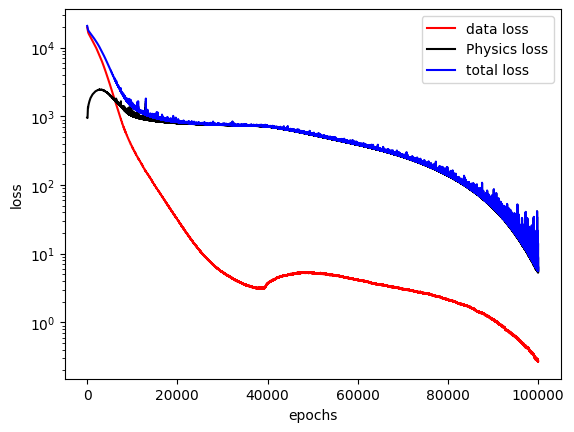

In [18]:
plt.figure()
plt.plot(h_data_loss,'r',label='data loss');
plt.plot(h_Phys_loss,'k',label='Physics loss');
plt.plot(h_loss,'b',label='total loss');
plt.yscale('log')
plt.legend()
plt.xlabel('epochs');plt.ylabel('loss')



In [ ]:
T_teste = np.linspace(0,30,350).reshape(-1,1)

In [207]:
prev = np.array(model_keras.predict(T_teste)).reshape(-1,2)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
tf.Tensor(84.93481408268174, shape=(), dtype=float64)


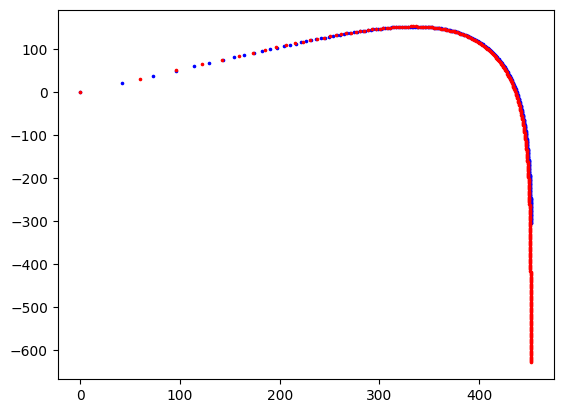

In [208]:
prev = np.array(model_keras.predict(T_teste)).reshape(-1,2)
plt.plot(prev[:,0],prev[:,1],"bo",markersize=1.6)
#plt.plot(y_data[:,0],y_data[:,1],"ro")

X,Y,t_ = makepath(angulo0,velocidade0,False,30,350)

print(tf.reduce_mean(np.abs(prev-np.stack((X,Y),axis=1))))
plt.plot(X,Y,"ro",markersize=1.6)